# Tutorial 5

## Training a model for a single GO term and checking its accuracy

In this tutorial, we are going to generate a simple model for a candidate GO term and check its accuracy as a classificator over the CAFA5 train set.

In [1]:
# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

We're going to create a one-dimensional convolutional model taking as input the one-hot-encoded protein sequences from the training set 

In [2]:
# Some imports
from manas_cafa.models.singleTermConv1DModel import singleTermConv1DModel
from manas_cafa.bio.protein import Protein
import pandas as pd
from Bio import SeqIO
import random
import numpy as np

Let's choose top scored GO term to create a model for:

In [3]:
ordered_candidates_df = pd.read_csv( '../data/go_terms_test_candidates_maxlen500_minmembers100_ordered.tsv', 
                                    index_col=0, sep='\t', header=None)
ordered_candidates_df

,1,2,3
0,,,
GO:0005793,8.166037,12661,103390.188669
GO:0008180,5.615446,14805,83136.673963
GO:0005791,5.236855,14792,77463.552732
GO:0016328,6.621535,11192,74108.217327
GO:0005801,5.131726,14266,73209.205868
...,...,...,...
GO:0006906,0.000000,624,0.000000
GO:0032024,0.000000,2077,0.000000
GO:0000166,0.000000,364,0.000000


In [4]:
ordered_candidates_df.index[0]

'GO:0005793'

### Getting the training set proteins to feed our model

We're going to read which proteins from the train set have the chosen GO term assigned:

In [5]:
GO_TERMS_TRAIN_SET = '../data/go_terms_train_set_maxlen500_minmembers100.tsv'

# Read the train set
train_set_df = pd.read_csv(GO_TERMS_TRAIN_SET, index_col=0, sep='\t', header=None, names=['go_term', 'proteins'] )
candidate_row = train_set_df.loc[ordered_candidates_df.index[0]]

In [6]:
candidate_row_proteins = candidate_row.proteins.split(',')

As negative examples, since is difficult to assert that a protein does not have an especific protein function (it could be that is only not assigned yet to it) we are going to get random proteins from the set of proteins that doesn't have it assigned. Since there are thousands of proteins there, we can trust that the big majority are going to be real negative examples:

In [7]:
# Load the proteins (max length 500)
other_proteins = []
for record in SeqIO.parse('../cafa-5-protein-function-prediction/Train/train_sequences.fasta', 'fasta'):
    if len(record.seq) <= 500:
        other_proteins.append(record.id)

other_proteins = list(set(other_proteins) - set(candidate_row_proteins))

In [8]:
# select random proteins from the other proteins
random.shuffle(other_proteins)
other_proteins = other_proteins[:len(candidate_row_proteins)*10]


Now we will compute all the one-hot encoded sequences for the candidate proteins and for the negative dataset. We are going to fix the lenght of the input to 500 aminoacides, completing with empty vectors for shorter proteins in order to feed the model with data properly shaped. 

In [9]:
# get the one-hot encoded sequence of the proteins in the candidate row
candidate_row_proteins_one_hot = []
for protein_id in candidate_row_proteins:
    protein = Protein(protein_id)
    protein.load_file('/data/uniprot/entries/'+protein_id[-2:]+"/"+protein_id+".xml")
    if len(protein.sequence) <= 500:
        candidate_row_proteins_one_hot.append(protein.one_hot_sequence())

In [10]:
# fix the length of the one-hot encoded sequences to 500
candidate_row_proteins_one_hot = [np.pad(seq, ((0, 500-len(seq)), (0,0)), 'constant') for seq in candidate_row_proteins_one_hot]

In [11]:
# get the one-hot encoded sequence of the other proteins
other_proteins_one_hot = []
for protein_id in other_proteins:
    protein = Protein(protein_id)
    try:
        protein.load_file('/data/uniprot/entries/'+protein_id[-2:]+"/"+protein_id+".xml")
        if len(protein.sequence) <= 500:
            other_proteins_one_hot.append(protein.one_hot_sequence())
    except:
        continue


In [12]:
# fix the length of the one-hot encoded sequences to 500
other_proteins_one_hot = [np.pad(seq, ((0, 500-len(seq)), (0,0)), 'constant') for seq in other_proteins_one_hot]

In [13]:
print(f'There are {len(candidate_row_proteins_one_hot)} positive examples')
print(f'And {len(other_proteins_one_hot)} negative examples')

There are 213 positive examples
And 2033 negative examples


### Creating the model

In this section we are going to create the simple model to be trained and validated. The input shape are vectors of 20 possible aminoacides with a fixed length of 500 aminoacides:

In [14]:
# create singleTermConv1DModel object
model = singleTermConv1DModel(input_shape=(500, 20), num_classes=2)

In [15]:
# compile the model
model.compile_model()

In [16]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 32)           1952      
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 64)           6208      
                                                                 
 dropout (Dropout)           (None, 496, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15872)             0         
                                                                 
 dense (Dense)               (None, 128)               2031744   
                                                        

We have created a model with ~2M parameters. The output is the probability of the protein (the one-hot encoded sequence of the protein used as input) to have assigned the GO term that we're training the model for.

As an usual practice, we train the model with 80% of the data and we reserve the remaning 20% for testing:

In [17]:
# create the train and test sets
eighty_percent_candidate = int(len(candidate_row_proteins_one_hot)*0.8)
eighty_percent_other = int(len(other_proteins_one_hot)*0.8)

x_train = np.array(candidate_row_proteins_one_hot[:eighty_percent_candidate] + other_proteins_one_hot[:eighty_percent_other])
y_train = np.array([[1,0]]*eighty_percent_candidate + [[0,1]]*eighty_percent_other)
x_test = np.array(candidate_row_proteins_one_hot[eighty_percent_candidate:] + other_proteins_one_hot[eighty_percent_other:])
y_test = np.array([[1,0]]*(len(candidate_row_proteins_one_hot)-eighty_percent_candidate) + [[0,1]]*(len(other_proteins_one_hot)-eighty_percent_other))


It's time to fit the model!

In [18]:
# fit the model
model.fit_model(x_train, y_train, x_test, y_test,
                epochs=10, batch_size=32)

Epoch 1/10


2023-08-18 10:54:19.979986: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


57/57 [==============================] - 2s 10ms/step - loss: 0.3385 - accuracy: 0.9026 - val_loss: 0.2913 - val_accuracy: 0.9044
Epoch 2/10
57/57 [==============================] - 0s 5ms/step - loss: 0.2066 - accuracy: 0.9053 - val_loss: 0.3286 - val_accuracy: 0.9044
Epoch 3/10
57/57 [==============================] - 0s 6ms/step - loss: 0.1459 - accuracy: 0.9204 - val_loss: 0.2772 - val_accuracy: 0.9111
Epoch 4/10
57/57 [==============================] - 0s 6ms/step - loss: 0.1011 - accuracy: 0.9504 - val_loss: 0.2619 - val_accuracy: 0.9178
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.9905 - val_loss: 0.4001 - val_accuracy: 0.9178
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.4203 - val_accuracy: 0.9200
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.4115 - val_accuracy: 0.9222
Epoch 8/10
57/57 [============

### Benchmarking our model on the test set

We have reserved 20% of our data for testing. Let's use our model to predict over those proteins the probability of the target term to be assigned and test that against the "truth" (if this proteins have the term assigned or not):

15/15 [==============================] - 0s 2ms/step


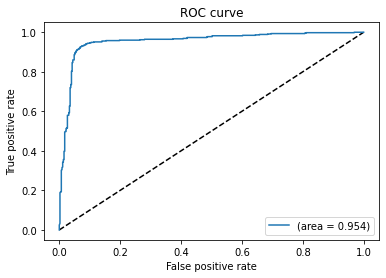

In [19]:
# make the imports for the plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# plot a roc curve for the test set
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# plot the roc curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# show the plot
plt.show()


Our appears to be a good classifier! Before use it to predict the target GO term over the test set of the competition, let's save it to a file so we don't have to train it again:


In [20]:
# save the model to a file in /data/models/<go_term[-2:]>/<go_term>, create the directory if it doesn't exist
model.model.save('/data/models/'+ordered_candidates_df.index[0][-2:]+'/'+ordered_candidates_df.index[0].replace("GO:","")+'.h5')

### Using our model on the test set of the competition

Now that we have constructed a model and assesed its classifying accuracy, let's load the test protein of the CAFA competition:

In [21]:
CANDIDATE_TERMS_TEST_SET = '../data/go_terms_test_candidates_maxlen500_minmembers100.tsv'

# Read the test set
test_set_df = pd.read_csv(CANDIDATE_TERMS_TEST_SET, index_col=0, sep='\t', header=None, names=['go_term', 'proteins'] )
candidate_row = test_set_df.loc[ordered_candidates_df.index[0]]


Get the one-hot encoded sequence of the proteins in the candidate row


In [22]:
candidate_row_proteins_one_hot = []
for protein_id in candidate_row.proteins.split(','):
    protein = Protein(protein_id)
    protein.load_file('/data/uniprot/entries/'+protein_id[-2:]+"/"+protein_id+".xml")
    # filter proteins with length > 500
    if len(protein.sequence) <= 500:
        candidate_row_proteins_one_hot.append(protein.one_hot_sequence())

# fix the length of the one-hot encoded sequences to 500
candidate_row_proteins_one_hot = [np.pad(seq, ((0, 500-len(seq)), (0,0)), 'constant') for seq in candidate_row_proteins_one_hot]

Let's use the constructed model to predict over all the candidates:  

In [23]:
# predict the probability of the proteins in the candidate row
predictions = model.predict(np.array(candidate_row_proteins_one_hot))

128/396 [========>.....................] - ETA: 0s

396/396 [==============================] - 1s 2ms/step


How many predictions we made?

In [24]:
print(f'We have predicted the target GO term over {predictions.shape[0]} proteins')

We have predicted the target GO term over 12660 proteins


Filter out only the possitive probabilities:

In [25]:
candidate_row_proteins_prob = [p[0] for p in predictions]


Let's order the results by probability and see the top-10 scored protein uniprot code:

In [26]:
candidate_row_proteins_prob_ordered = list(zip(candidate_row.proteins.split(','), candidate_row_proteins_prob))
candidate_row_proteins_prob_ordered.sort(key=lambda x: x[1], reverse=True)
candidate_row_proteins_prob_ordered[0:10]

[('P59190', 0.9978745),
 ('P56520', 0.9948442),
 ('Q6NT76', 0.9768891),
 ('Q3HNG7', 0.9768891),
 ('Q9YH06', 0.9734062),
 ('P30681', 0.9683884),
 ('P10247', 0.96442777),
 ('P0C5I2', 0.95771515),
 ('Q00977', 0.946732),
 ('P08033', 0.9420413)]

Since for the competition we're interested in positive predictions, let's keep only those with p>0.4 for submission:

In [27]:
# candidate_row_proteins_prob_ordered to file
with open('../data/candidate_row_proteins_prob_ordered.tsv', 'w') as f:
    f.write('protein_id\tprobability\n')
    for protein_id, prob in candidate_row_proteins_prob_ordered:
        if prob>0.4:
            f.write(protein_id+'\t'+ordered_candidates_df.index[0]+'\t'+str(prob.round(3))+'\n')
        